In [1]:
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import os
import io
from PIL import Image
import seaborn as sns

In [2]:
train_data_dir = '4/train'
val_data_dir = '4/val'
test_data_dir = '4/test'

In [3]:
def get_data_loaders(batch_size=16, num_workers=2):
    transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])
    trainset = torchvision.datasets.ImageFolder(root= train_data_dir, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    valnset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
    valloader = torch.utils.data.DataLoader(valnset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    testset = torchvision.datasets.ImageFolder(root= test_data_dir, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    return trainloader, valloader, testloader

class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

In [18]:
classes, class_to_idx = find_classes(test_data_dir)

In [22]:
def read_img(img_path):
    with open(img_path, 'rb') as f:
        image_bytes = f.read()
        image = Image.open(io.BytesIO(image_bytes))
    return np.asarray(image)

def occlude_img(img,i,j,N):
    img_copy = img.copy()
    img_copy[i:i+N,j:j+N,:] = 0
    return img_copy

def transform_image(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])
    img_copy = image.copy()
    return transform(img_copy).unsqueeze(0)

def get_prediction(image, label):
    tensor = transform_image(image)
    tensor=tensor.cuda()
    output = net.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1).cpu().detach().numpy()
    idx = class_to_idx[label]
    return probs[0][idx]

In [23]:
def get_preds_list_for_occlusion(img, label, N = 4, stride_length = 1):
    preds_list = []
    for y in tqdm(range(0,80,stride_length)):
        preds_x_list = []
        for x in range(0,80,stride_length):
            occluded_img = occlude_img(img,y,x,N)
            pred = get_prediction(occluded_img, label)
            preds_x_list.append(pred)
        preds_list.append(preds_x_list)
    return preds_list

def convert_to_heatmap(img, preds_list):
    f, axarr = plt.subplots(1,2, figsize=(14,7))
    axarr[0].imshow(img)
    axarr[1] = sns.heatmap(preds_list, linewidth=0)
    plt.show()


In [24]:
trainloader, valloader, testloader = get_data_loaders()
net = Net()
net.load_state_dict(torch.load(f"models_13/model38.pth"))
if torch.cuda.is_available():
    net = net.cuda()

net.eval()

Net(
  (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_final): Linear(in_features=256, out_features=33, bias=True)
)

100%|██████████| 80/80 [00:17<00:00,  4.46it/s]


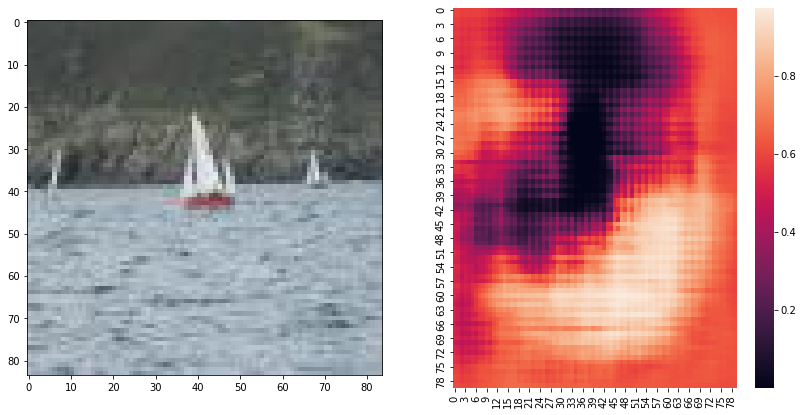

In [8]:
directory = "4/test/" 
label = "yawl"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[1]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 8, stride_length = 1)
convert_to_heatmap(img, preds_list)

100%|██████████| 40/40 [00:03<00:00, 10.37it/s]


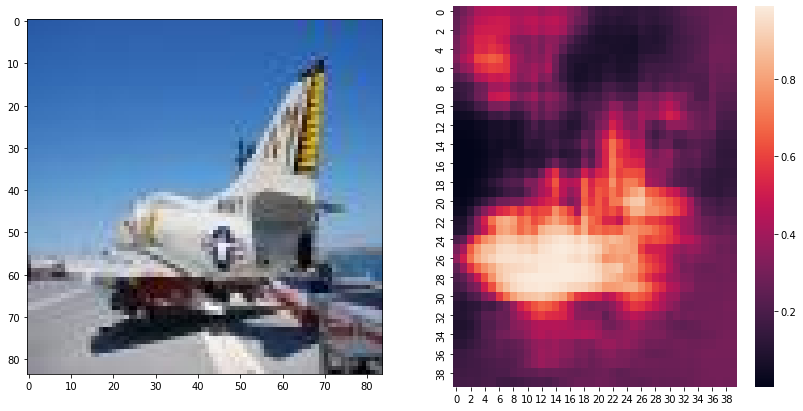

In [29]:
directory = "4/test/" 
label = "aircraft_carrier"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[1]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 16, stride_length = 2)
convert_to_heatmap(img, preds_list)

100%|██████████| 40/40 [00:03<00:00, 10.32it/s]


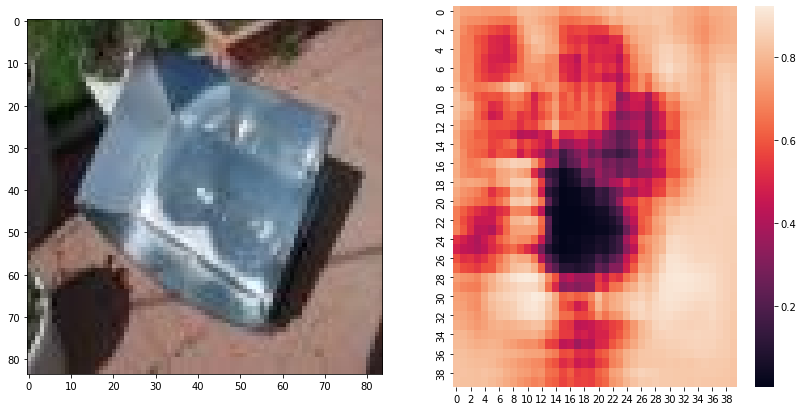

In [36]:
directory = "4/test/" 
label = "solar_dish"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[2]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 16, stride_length = 2)
convert_to_heatmap(img, preds_list)

100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


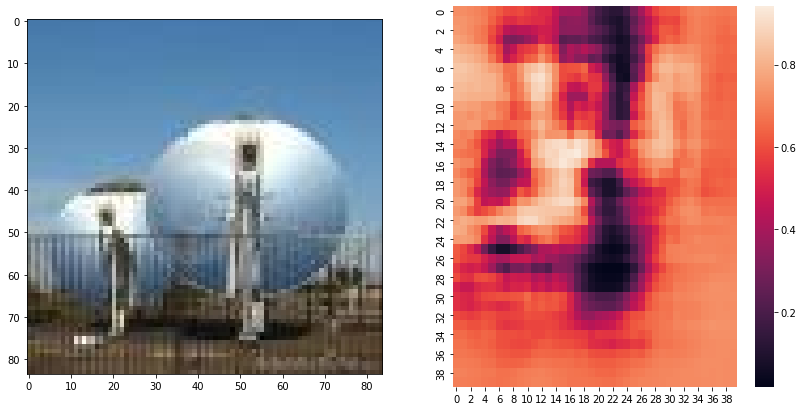

In [37]:
directory = "4/test/" 
label = "solar_dish"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[4]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 16, stride_length = 2)
convert_to_heatmap(img, preds_list)

100%|██████████| 40/40 [00:03<00:00, 10.32it/s]


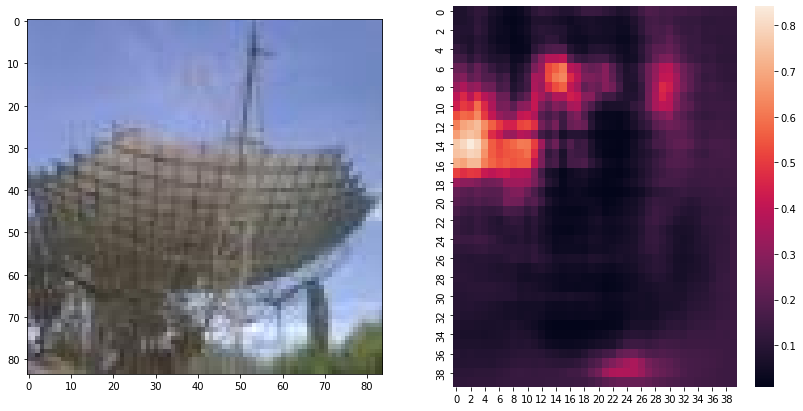

In [38]:
directory = "4/test/" 
label = "solar_dish"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[6]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 16, stride_length = 2)
convert_to_heatmap(img, preds_list)

100%|██████████| 40/40 [00:03<00:00, 10.32it/s]


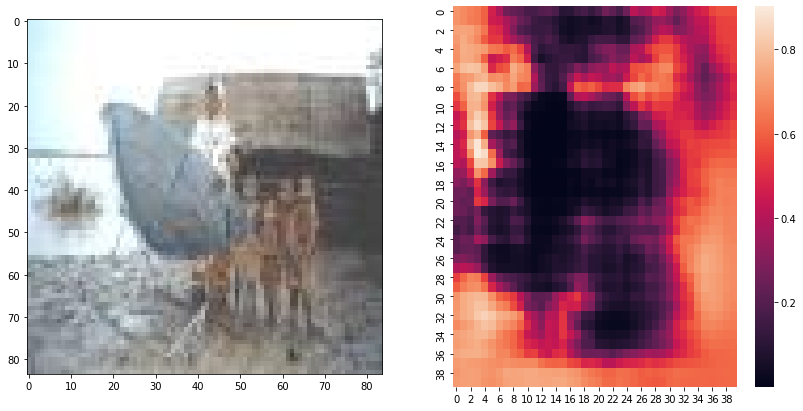

In [41]:
directory = "4/test/" 
label = "solar_dish"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[9]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 16, stride_length = 2)
convert_to_heatmap(img, preds_list)

100%|██████████| 40/40 [00:03<00:00, 10.33it/s]


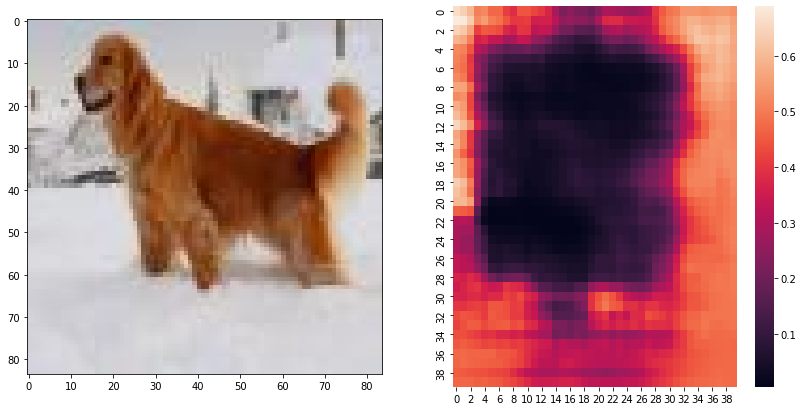

In [44]:
directory = "4/test/" 
label = "golden_retriever"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[0]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 16, stride_length = 2)
convert_to_heatmap(img, preds_list)

100%|██████████| 80/80 [00:15<00:00,  5.20it/s]


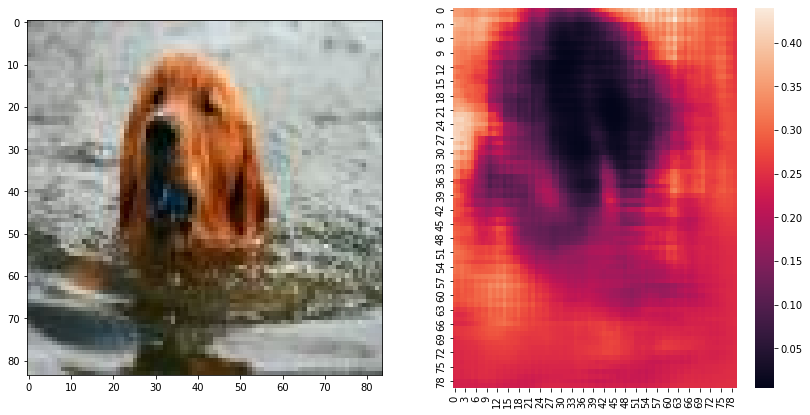

In [52]:
directory = "4/test/" 
label = "golden_retriever"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[18]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 12, stride_length = 1)
convert_to_heatmap(img, preds_list)

100%|██████████| 40/40 [00:03<00:00, 10.21it/s]


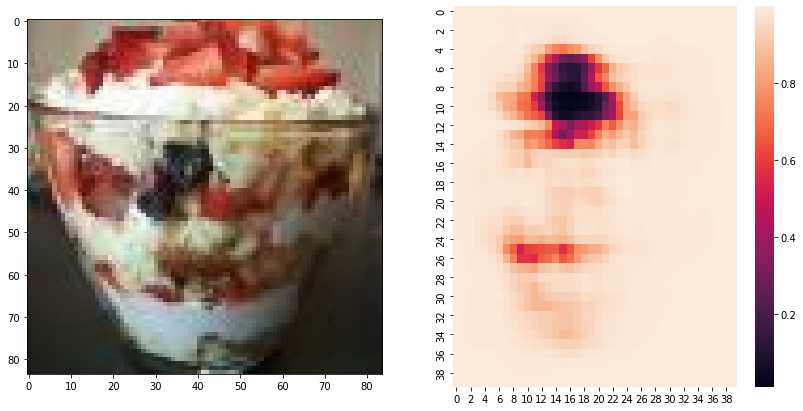

In [54]:
directory = "4/test/" 
label = "trifle"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[18]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 12, stride_length = 2)
convert_to_heatmap(img, preds_list)

100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


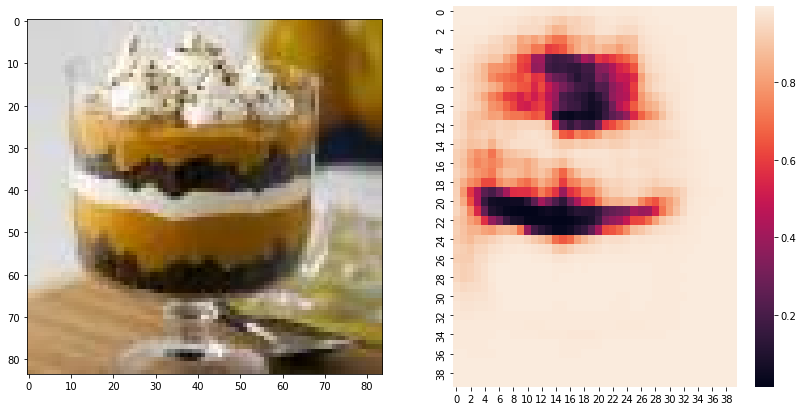

In [55]:
directory = "4/test/" 
label = "trifle"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[2]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 12, stride_length = 2)
convert_to_heatmap(img, preds_list)

100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


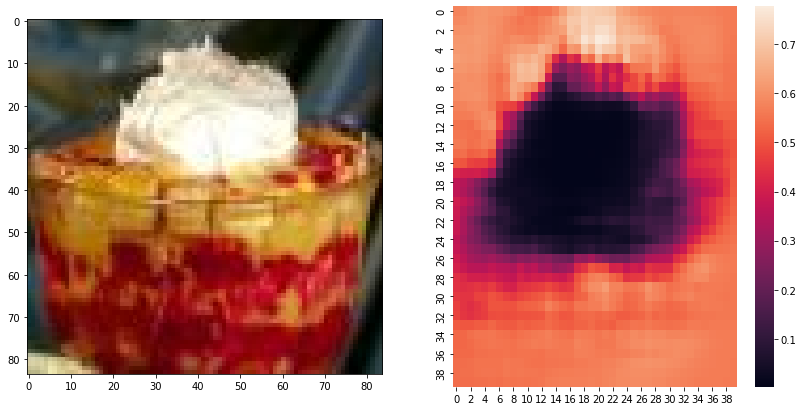

In [57]:
directory = "4/test/" 
label = "trifle"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[6]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 12, stride_length = 2)
convert_to_heatmap(img, preds_list)

100%|██████████| 40/40 [00:03<00:00, 10.36it/s]


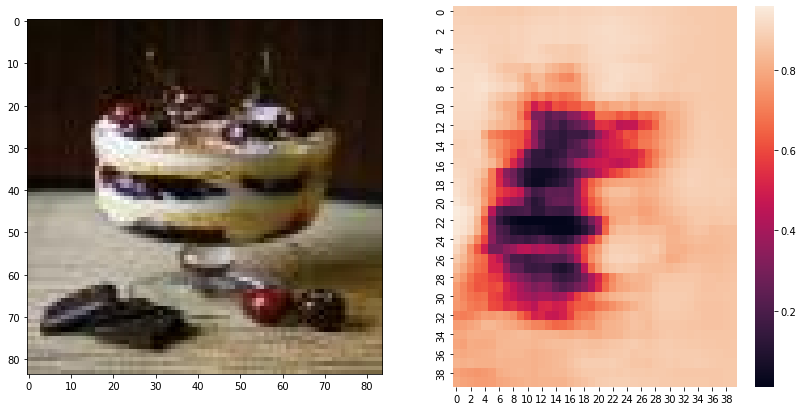

In [58]:
directory = "4/test/" 
label = "trifle"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[9]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 12, stride_length = 2)
convert_to_heatmap(img, preds_list)

100%|██████████| 40/40 [00:03<00:00, 10.30it/s]


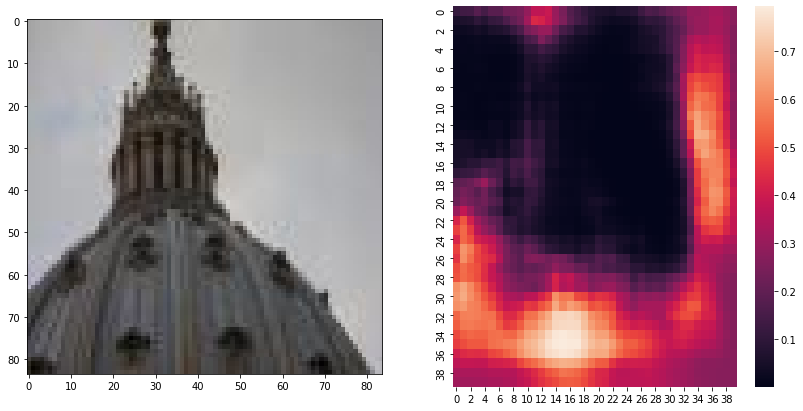

In [62]:
directory = "4/test/" 
label = "dome"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[8]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 12, stride_length = 2)
convert_to_heatmap(img, preds_list)

100%|██████████| 80/80 [00:16<00:00,  4.92it/s]


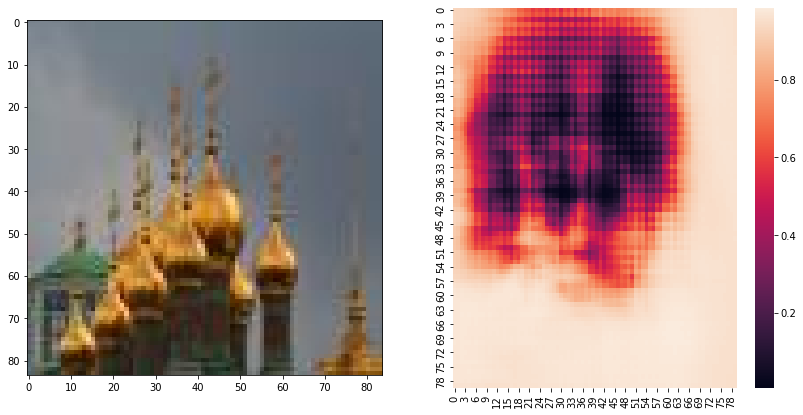

In [64]:
directory = "4/test/" 
label = "dome"
base = directory + label
files = os.listdir(base)
img_path = base + "/" + files[13]

img = read_img(img_path)
preds_list = get_preds_list_for_occlusion(img, label, N = 12, stride_length = 1)
convert_to_heatmap(img, preds_list)